In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, torch, time
warnings.filterwarnings('ignore')
import torch.nn as nn
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

In [2]:
df = pd.read_csv('/kaggle/input/egg-sales-of-a-local-shop-for-30-years/train_egg_sales.csv',delimiter=';',index_col='Date')
df.head()

,Egg Sales
Date,
1993-01-01,91
1993-01-02,124
1993-01-03,112
1993-01-04,115
1993-01-05,107


In [3]:
df.shape

(10592, 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10592 entries, 1993-01-01 to 2021-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Egg Sales  10592 non-null  int64
dtypes: int64(1)
memory usage: 165.5+ KB


In [5]:
df.describe()

,Egg Sales
count,10592.000000
mean,366.326095
std,155.202620
min,0.000000
25%,235.000000
50%,366.000000
75%,499.000000
max,713.000000


In [6]:
df.isna().sum()

Egg Sales    0
dtype: int64

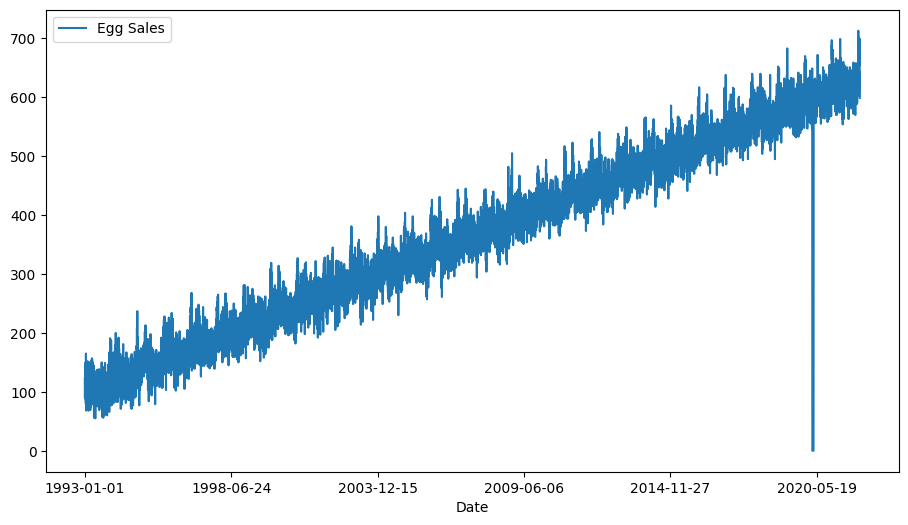

In [7]:
df.plot(figsize=(11,6));

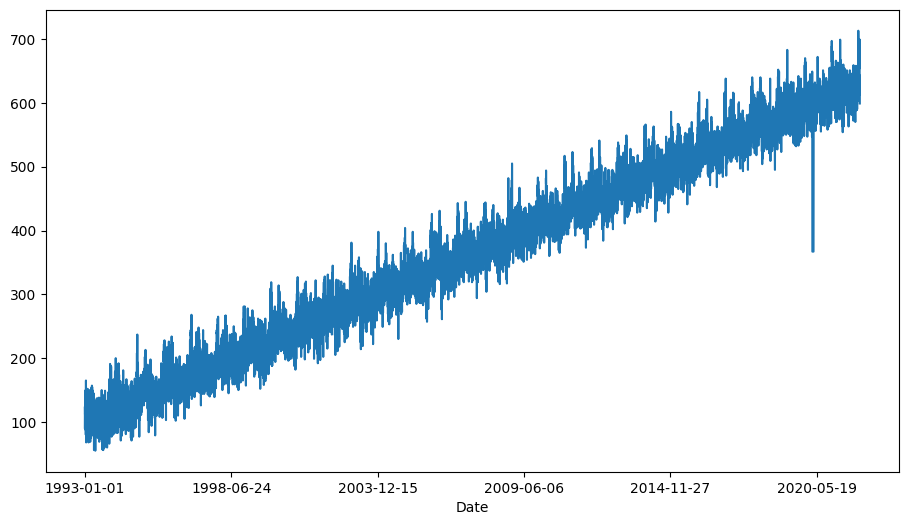

In [8]:
df['Egg Sales'].replace(to_replace=0,value=df[df['Egg Sales']!=0].mean()['Egg Sales'],inplace=True) # Filling in 0 values with mean value of Egg Sales
df['Egg Sales'].plot(figsize=(11,6));

In [9]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['1993-01-01', '1993-01-02', '1993-01-03', '1993-01-04',
               '1993-01-05', '1993-01-06', '1993-01-07', '1993-01-08',
               '1993-01-09', '1993-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=10592, freq=None)

In [10]:
df.shape

(10592, 1)

In [11]:
y = df['Egg Sales'].astype(float).values
y

array([ 91., 124., 112., ..., 613., 643., 599.])

In [12]:
test_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]

In [13]:
train_set.shape, test_set.shape

((10580,), (12,))

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [15]:
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm

tensor([0.0547, 0.1049, 0.0866,  ..., 0.9134, 0.9347, 0.9544])

In [16]:
def input_data(sequence,window_size):
    output_sequences = []
    L = len(sequence)

    for i in range(L-window_size):
        window = sequence[i:i+window_size]
        label = sequence[i+window_size:i+window_size+1]
        output_sequences.append((window,label))

    return output_sequences

In [17]:
train_data = input_data(train_norm,window_size=12)
train_data[0]

(tensor([0.0547, 0.1049, 0.0866, 0.0912, 0.0790, 0.0745, 0.0593, 0.0821, 0.0502,
         0.0532, 0.1444, 0.0821]),
 tensor([0.0729]))

In [18]:
len(train_data)

10568

In [19]:
class LSTM(nn.Module):

    def __init__(self,input_size=1,hidden_size=150,output_size=1):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size)
        self.linear = nn.Linear(in_features=hidden_size,out_features=output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size),torch.zeros(1,1,self.hidden_size))

    def forward(self,sequence):
        lstm_output, self.hidden = self.lstm(sequence.view(len(sequence),1,-1),self.hidden)
        pred = self.linear(lstm_output.view(len(lstm_output),-1))
        return pred[-1]

In [20]:
torch.manual_seed(28)
lstm = LSTM()
lstm

LSTM(
  (lstm): LSTM(1, 150)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [21]:
summary(lstm)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              91,800
├─Linear: 1-2                            151
Total params: 91,951
Trainable params: 91,951
Non-trainable params: 0

In [22]:
total_params = 0

for param in lstm.parameters():
    total_params += param.numel()
    print(param.numel())

print("Total parameters:", total_params)

600
90000
600
600
150
1
Total parameters: 91951


In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=lstm.parameters(),lr=0.001)

In [24]:
epochs = 100

losses = []
start_time = time.time()

for i in range(1,epochs+1):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        lstm.hidden = (torch.zeros(1,1,lstm.hidden_size),torch.zeros(1,1,lstm.hidden_size))
        y_pred = lstm(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.0005614272085949779
Epoch 2 -> Loss: 0.001195788267068565
Epoch 3 -> Loss: 0.0013484180672094226
Epoch 4 -> Loss: 0.0011984898010268807
Epoch 5 -> Loss: 0.0009287631837651134
Epoch 6 -> Loss: 0.0009414124069735408
Epoch 7 -> Loss: 0.0014571157516911626
Epoch 8 -> Loss: 0.0011623585596680641
Epoch 9 -> Loss: 0.0010109766153618693
Epoch 10 -> Loss: 0.0010049249976873398
Epoch 11 -> Loss: 0.0012190260458737612
Epoch 12 -> Loss: 0.0021390942856669426
Epoch 13 -> Loss: 0.0013105857651680708
Epoch 14 -> Loss: 0.001953165978193283
Epoch 15 -> Loss: 0.0014727016678079963
Epoch 16 -> Loss: 0.002605500863865018
Epoch 17 -> Loss: 0.0014394093304872513
Epoch 18 -> Loss: 0.0016483166255056858
Epoch 19 -> Loss: 0.001391000347211957
Epoch 20 -> Loss: 0.0033148243092000484
Epoch 21 -> Loss: 0.0014011557213962078
Epoch 22 -> Loss: 0.001535743591375649
Epoch 23 -> Loss: 0.0015913160750642419
Epoch 24 -> Loss: 0.0014804293168708682
Epoch 25 -> Loss: 0.001383385737426579
Epoch 26 -> Los

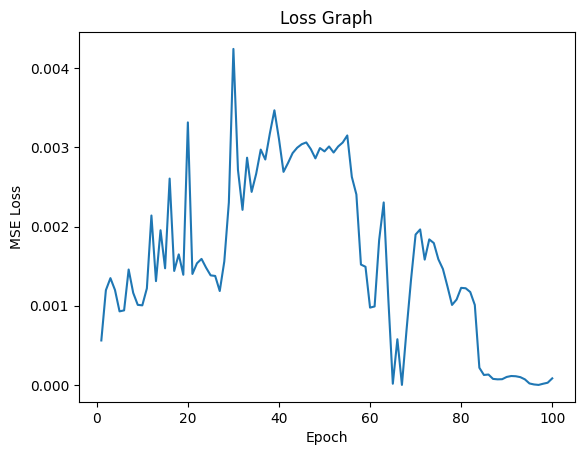

In [25]:
plt.plot(range(1,epochs+1),losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.show();

In [26]:
test_size = 12
window_size = 12
predictions = train_norm[-window_size:].tolist()

lstm.eval()

for i in range(test_size):
    sequence = torch.FloatTensor(predictions[-window_size:])

    with torch.no_grad():
        lstm.hidden = (torch.zeros(1,1,lstm.hidden_size),torch.zeros(1,1,lstm.hidden_size))
        predictions.append(lstm(sequence).item())

In [27]:
predictions[-12:]

[0.9456348419189453,
 0.9435285329818726,
 0.9444621801376343,
 0.9505534172058105,
 0.9511631727218628,
 0.9474706053733826,
 0.9453684091567993,
 0.9459141492843628,
 0.94789719581604,
 0.9471574425697327,
 0.9450900554656982,
 0.9449535012245178]

In [28]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions

array([[679.99998152],
       [658.99998403],
       [713.        ],
       [702.00000691],
       [647.99999094],
       [646.00001359],
       [681.99999809],
       [678.99999285],
       [681.99999809],
       [656.000018  ],
       [670.00001633],
       [682.99998677],
       [677.22772598],
       [675.8417747 ],
       [676.45611453],
       [680.46414852],
       [680.86536765],
       [678.43565834],
       [677.05241323],
       [677.41151023],
       [678.71635485],
       [678.22959721],
       [676.8692565 ],
       [676.77940381]])

In [29]:
true_predictions[-12:]

array([[677.22772598],
       [675.8417747 ],
       [676.45611453],
       [680.46414852],
       [680.86536765],
       [678.43565834],
       [677.05241323],
       [677.41151023],
       [678.71635485],
       [678.22959721],
       [676.8692565 ],
       [676.77940381]])

In [30]:
df.index

DatetimeIndex(['1993-01-01', '1993-01-02', '1993-01-03', '1993-01-04',
               '1993-01-05', '1993-01-06', '1993-01-07', '1993-01-08',
               '1993-01-09', '1993-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=10592, freq=None)

In [31]:
x = pd.date_range(start='2021-01-01',end='2021-12-31',freq='MS')
x

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', freq='MS')

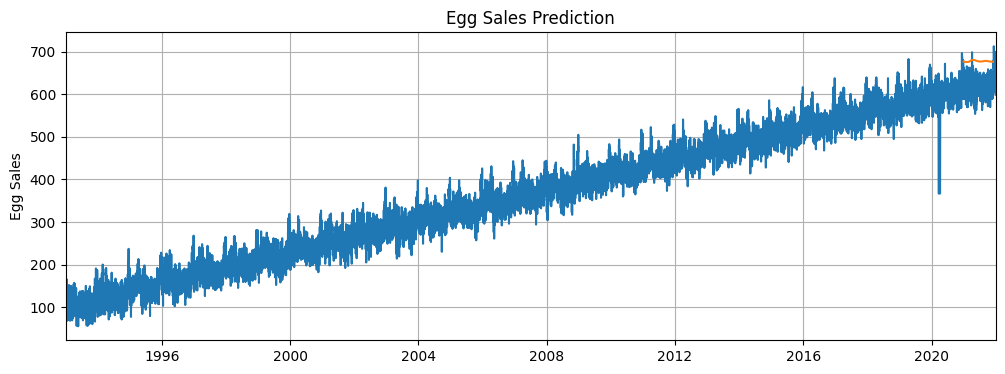

In [32]:
plt.figure(figsize=(12,4))
plt.title('Egg Sales Prediction')
plt.ylabel('Egg Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Egg Sales'])
plt.plot(x,true_predictions[-test_size:])
plt.show();

In [33]:
print("MAE:", mean_absolute_error(df[-test_size:].values,true_predictions[-test_size:]))
print("MAPE:", mean_absolute_percentage_error(df[-test_size:].values,true_predictions[-test_size:]))
print("MSE:", mean_squared_error(df[-test_size:].values,true_predictions[-test_size:]))
print("MSLE:", mean_squared_log_error(df[-test_size:].values,true_predictions[-test_size:]))
print("RMSE:", np.sqrt(mean_squared_error(df[-test_size:].values,true_predictions[-test_size:])))

MAE: 26.45690529545148
MAPE: 0.04133047183779306
MSE: 1170.8371957893685
MSLE: 0.0027759190026398046
RMSE: 34.21749838590438


In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=lstm.parameters(),lr=0.001)

In [35]:
lstm.train() # Set model back to training model to train it on complete data

y_norm = scaler.transform(y.reshape(-1,1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size=12)
losses = []

start_time = time.time()

for i in range(1,epochs+1):
    
    for seq, y_train in all_data:
        optimizer.zero_grad()
        lstm.hidden = (torch.zeros(1,1,lstm.hidden_size),torch.zeros(1,1,lstm.hidden_size))
        y_pred = lstm(seq)
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())
    print(f"Epoch {i} -> Loss: {loss.item()}")

print(f"Total time elapsed in LSTM model training on whole data: {(time.time()-start_time)/60} minutes.")

Epoch 1 -> Loss: 0.012887189164757729
Epoch 2 -> Loss: 0.014372305013239384
Epoch 3 -> Loss: 0.017626797780394554
Epoch 4 -> Loss: 0.018906427547335625
Epoch 5 -> Loss: 0.019690757617354393
Epoch 6 -> Loss: 0.018658310174942017
Epoch 7 -> Loss: 0.019215179607272148
Epoch 8 -> Loss: 0.019222384318709373
Epoch 9 -> Loss: 0.01913970336318016
Epoch 10 -> Loss: 0.018545929342508316
Epoch 11 -> Loss: 0.016953086480498314
Epoch 12 -> Loss: 0.021728716790676117
Epoch 13 -> Loss: 0.017994198948144913
Epoch 14 -> Loss: 0.01793820969760418
Epoch 15 -> Loss: 0.018519768491387367
Epoch 16 -> Loss: 0.018821222707629204
Epoch 17 -> Loss: 0.021555783227086067
Epoch 18 -> Loss: 0.017697550356388092
Epoch 19 -> Loss: 0.03634430468082428
Epoch 20 -> Loss: 0.02005314640700817
Epoch 21 -> Loss: 0.018359897658228874
Epoch 22 -> Loss: 0.015512713231146336
Epoch 23 -> Loss: 0.017759231850504875
Epoch 24 -> Loss: 0.012112542055547237
Epoch 25 -> Loss: 0.014652322977781296
Epoch 26 -> Loss: 0.017825953662395477

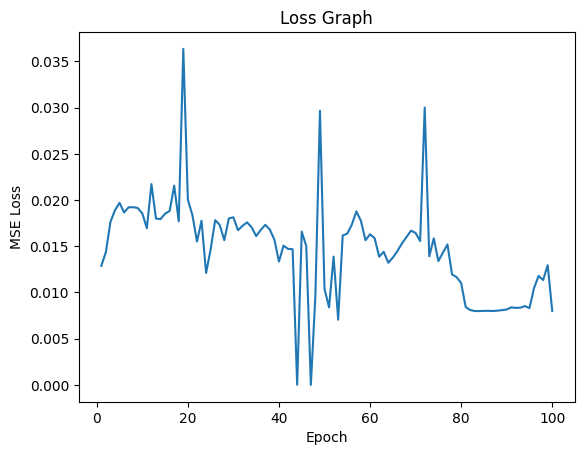

In [36]:
plt.plot(range(1,epochs+1),losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Graph')
plt.show();

In [37]:
forecast_horizon = 24
window_size = 12
predictions = y_norm[-window_size:].tolist()

lstm.eval()

for i in range(forecast_horizon):
    sequence = torch.FloatTensor(predictions[-window_size:])

    with torch.no_grad():
        lstm.hidden = (torch.zeros(1,1,lstm.hidden_size),torch.zeros(1,1,lstm.hidden_size))
        predictions.append(lstm(sequence).item())

In [38]:
predictions

[0.9711246490478516,
 0.9513677954673767,
 0.9088146090507507,
 0.9802431464195251,
 0.9194529056549072,
 0.9696048498153687,
 0.978723406791687,
 0.9513677954673767,
 0.9255319237709045,
 0.848024308681488,
 0.8936170339584351,
 0.826747715473175,
 0.9223153591156006,
 0.9014108180999756,
 0.940181314945221,
 0.9209170341491699,
 0.9288229942321777,
 0.9592047333717346,
 0.9656273722648621,
 1.0344033241271973,
 1.0209391117095947,
 1.0423963069915771,
 1.0047624111175537,
 0.9951397776603699,
 0.9427322745323181,
 0.9263983368873596,
 0.9080313444137573,
 0.8725677728652954,
 0.8523440957069397,
 0.773137629032135,
 0.7613129615783691,
 0.7386404275894165,
 0.8034574389457703,
 0.8592429161071777,
 0.9598022699356079,
 1.0467348098754883]

In [39]:
true_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
true_predictions[-24:]

array([[661.8835063 ],
       [648.12831831],
       [673.63930523],
       [660.96340847],
       [666.1655302 ],
       [686.15671456],
       [690.38281095],
       [735.63738728],
       [726.7779355 ],
       [740.89677   ],
       [716.13366652],
       [709.8019737 ],
       [675.31783664],
       [664.57010567],
       [652.48462462],
       [629.14959455],
       [615.84241498],
       [563.7245599 ],
       [555.94392872],
       [541.02540135],
       [583.67499483],
       [620.3818388 ],
       [686.54989362],
       [743.7515049 ]])

In [40]:
df.index

DatetimeIndex(['1993-01-01', '1993-01-02', '1993-01-03', '1993-01-04',
               '1993-01-05', '1993-01-06', '1993-01-07', '1993-01-08',
               '1993-01-09', '1993-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=10592, freq=None)

In [41]:
x = pd.date_range(start='2022-01-01',end='2023-12-31',freq='ME')
x

DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [42]:
len(true_predictions)

36

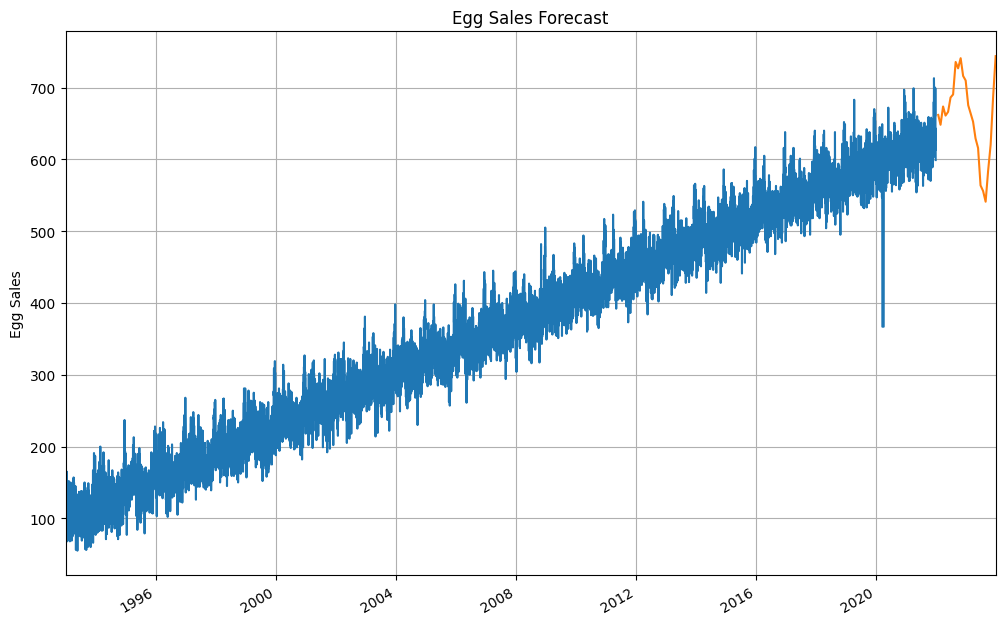

In [43]:
fig = plt.figure(figsize=(12,8))
plt.title('Egg Sales Forecast')
plt.ylabel('Egg Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['Egg Sales'])
plt.plot(x,true_predictions[-forecast_horizon:])
plt.show();

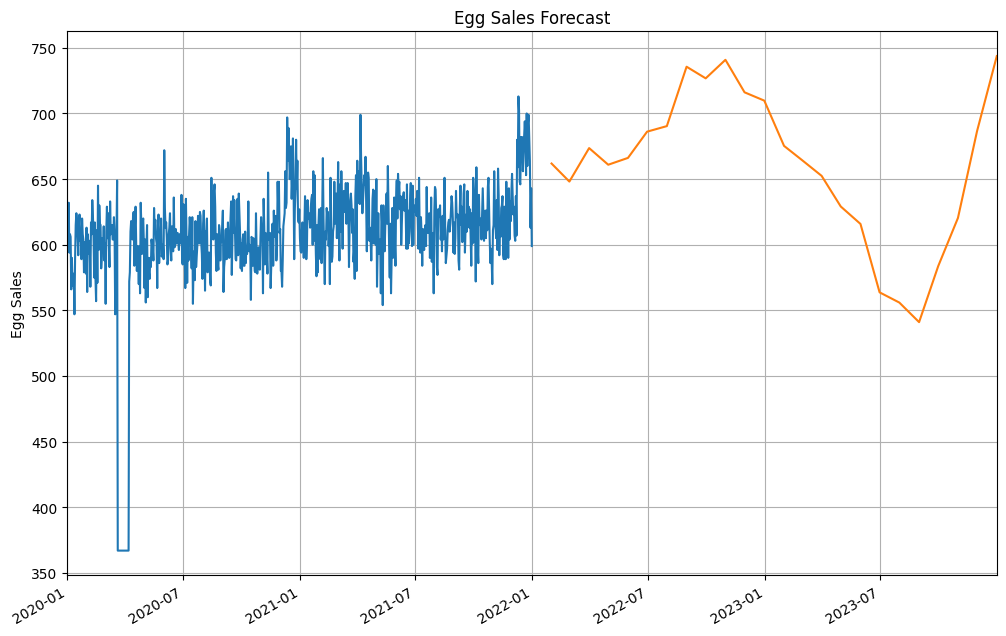

In [44]:
fig = plt.figure(figsize=(12,8))
plt.title('Egg Sales Forecast')
plt.ylabel('Egg Sales')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['Egg Sales']['2020-01-01':])
plt.plot(x,true_predictions[-forecast_horizon:])
plt.show();

In [45]:
test_df = pd.read_csv("/kaggle/input/egg-sales-of-a-local-shop-for-30-years/test_egg_sales.csv",index_col='Date')
test_df.head()

""
Date
2022-01-01
2022-01-02
2022-01-03
2022-01-04
2022-01-05


In [46]:
test_df.index = pd.to_datetime(test_df.index)
test_df = test_df.resample('M').sum()
test_df.shape

(12, 0)

In [47]:
test_df['Egg Sales'] = true_predictions[-test_size:]
test_df.head()

,Egg Sales
Date,
2022-01-31,675.317837
2022-02-28,664.570106
2022-03-31,652.484625
2022-04-30,629.149595
2022-05-31,615.842415


In [48]:
test_df.to_csv('test_egg_sales.csv')